In [14]:
import numpy as np
import numpy.ma as ma

from astropy.table import QTable

import sys
#sys.path.insert(1,"/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/")
sys.path.insert(1, '/home/kelly/Documents/RotationCurves/spirals/')
from DRP_rotation_curve import extract_data
from DRP_vel_map_functions import model_vel_map, find_center, find_phi, deproject_spaxel
from DRP_vel_map_plottingFunctions import plot_rot_curve

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
#MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/dr16/manga/spectro/'
MANGA_FOLDER = '/home/kelly/Documents/Data/SDSS/dr16/manga/spectro/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'

# Sample galaxy properties

In [3]:
#gal_ID = '7443-12705'
gal_ID = '9002-12701'

manga_plate, manga_IFU = gal_ID.split('-')

In [4]:
Ha_vel, Ha_vel_ivar, Ha_vel_mask, r_band, r_band_ivar = extract_data(VEL_MAP_FOLDER, gal_ID)

mr_band = ma.array(r_band, mask=Ha_vel_mask)
mHa_vel = ma.array(Ha_vel, mask=Ha_vel_mask)
mHa_vel_ivar = ma.array(Ha_vel_ivar, mask=Ha_vel_mask)

In [5]:
oneD_fit_file = '../spirals/DRPall-master_file_30.txt'

oneD_fit_parameters = QTable.read(oneD_fit_file, format='ascii.ecsv')

gal_oneD_fit_parameters_boolean = np.logical_and(oneD_fit_parameters['MaNGA_plate'] == int(manga_plate), 
                                                 oneD_fit_parameters['MaNGA_IFU'] == int(manga_IFU))

gal_oneD_fit_parameters_row = oneD_fit_parameters[gal_oneD_fit_parameters_boolean]

In [15]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

MANGA_FIBER_DIAMETER = 2*(1/60)*(1/60)*(np.pi/180) # angular fiber diameter (2") in radians
MANGA_SPAXEL_SIZE = 0.5*(1/60)*(1/60)*(np.pi/180)  # spaxel size (0.5") in radians


dist_to_galaxy_Mpc = c*gal_oneD_fit_parameters_row['redshift'][0]/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

pix_scale_factor = dist_to_galaxy_kpc*np.tan(MANGA_SPAXEL_SIZE)

In [45]:
################################################################################
# Inclination angle (from photometry)
#-------------------------------------------------------------------------------
i_angle = np.arccos(gal_oneD_fit_parameters_row['ba'][0])
################################################################################


################################################################################
# Photometric center of galaxy
#-------------------------------------------------------------------------------
center = np.unravel_index(ma.argmax(mr_band), mr_band.shape)
################################################################################


################################################################################
# Systemic velocity (velocity at galaxy's center)
#-------------------------------------------------------------------------------
v_sys = mHa_vel[center]
################################################################################


################################################################################
# Rotation angle (from photometry)
#-------------------------------------------------------------------------------
phi = gal_oneD_fit_parameters_row['phi'][0].value

phi_guess = find_phi(center, phi, mHa_vel)
################################################################################


################################################################################
# Maximum velocity
#-------------------------------------------------------------------------------
v_max = gal_oneD_fit_parameters_row['avg_v_max'][0].value

v_max_index = np.unravel_index(ma.argmax(np.abs(mHa_vel)), mHa_vel.shape)
v_max_guess = np.abs(mHa_vel[v_max_index]/np.sin(i_angle))
################################################################################


################################################################################
# Turn radius
#-------------------------------------------------------------------------------
r_turn = gal_oneD_fit_parameters_row['avg_r_turn'][0].value

r_turn_guess_spaxels,_ = deproject_spaxel(v_max_index, 
                                          center, 
                                          phi_guess, 
                                          i_angle)

r_turn_guess = 0.5*r_turn_guess_spaxels*pix_scale_factor
################################################################################


################################################################################
# alpha
#-------------------------------------------------------------------------------
alpha = gal_oneD_fit_parameters_row['avg_alpha'][0]

alpha_guess = 2
################################################################################


params = [v_sys, i_angle, center[0], center[1], phi_guess, v_max, r_turn, alpha]
initial_guess_params = [v_sys, i_angle, center[0], center[1], phi_guess, v_max_guess, r_turn_guess, alpha_guess]
fit_params = [310.12004301273714, # v_sys
              0.9428241726200765, # b/a
              52.99996502794504, # center x
              52.99996502794504, # center y
              287.64758659519964, # phi (degrees)
              713.3502678525326, # V_max
              12.614076177864092, # R_turn
              14.99995449095048] # alpha
print(initial_guess_params)

best_fit_values = {'v_sys':v_sys,
                   'ba':gal_oneD_fit_parameters_row['ba'][0],
                   'x0':center[0],
                   'y0':center[1],
                   'phi':phi_guess,
                   'r_turn':r_turn,
                   'v_max':v_max,
                   'alpha':alpha}
best_fit_values_degrees = {'v_sys':v_sys,
                           'ba':gal_oneD_fit_parameters_row['ba'][0],
                           'x0':center[0],
                           'y0':center[1],
                           'phi':phi_guess*180./np.pi,
                           'r_turn':r_turn,
                           'v_max':v_max,
                           'alpha':alpha}
fit_params_dict = {'v_sys':fit_params[0], 
                   'ba': fit_params[1], #np.cos(fit_params[1]), 
                   'x0': fit_params[2], 
                   'y0': fit_params[3], 
                   'phi': fit_params[4], #*180./np.pi,
                   'v_max': fit_params[5], 
                   'r_turn': fit_params[6], 
                   'alpha': fit_params[7]}

[8.389117, 0.5173335481298867, 38, 38, 5.750388646423278, 723.1253742376196, 4.518301763520736, 2]


In [46]:
map_shape = mHa_vel.shape

# Test `model_vel_map`

In [47]:
model_map_BB = model_vel_map(fit_params, 
                             map_shape, 
                             pix_scale_factor, 
                             'BB')

model_map_tanh = model_vel_map(params[:-1], map_shape, pix_scale_factor, 'tanh')

<IPython.core.display.Javascript object>


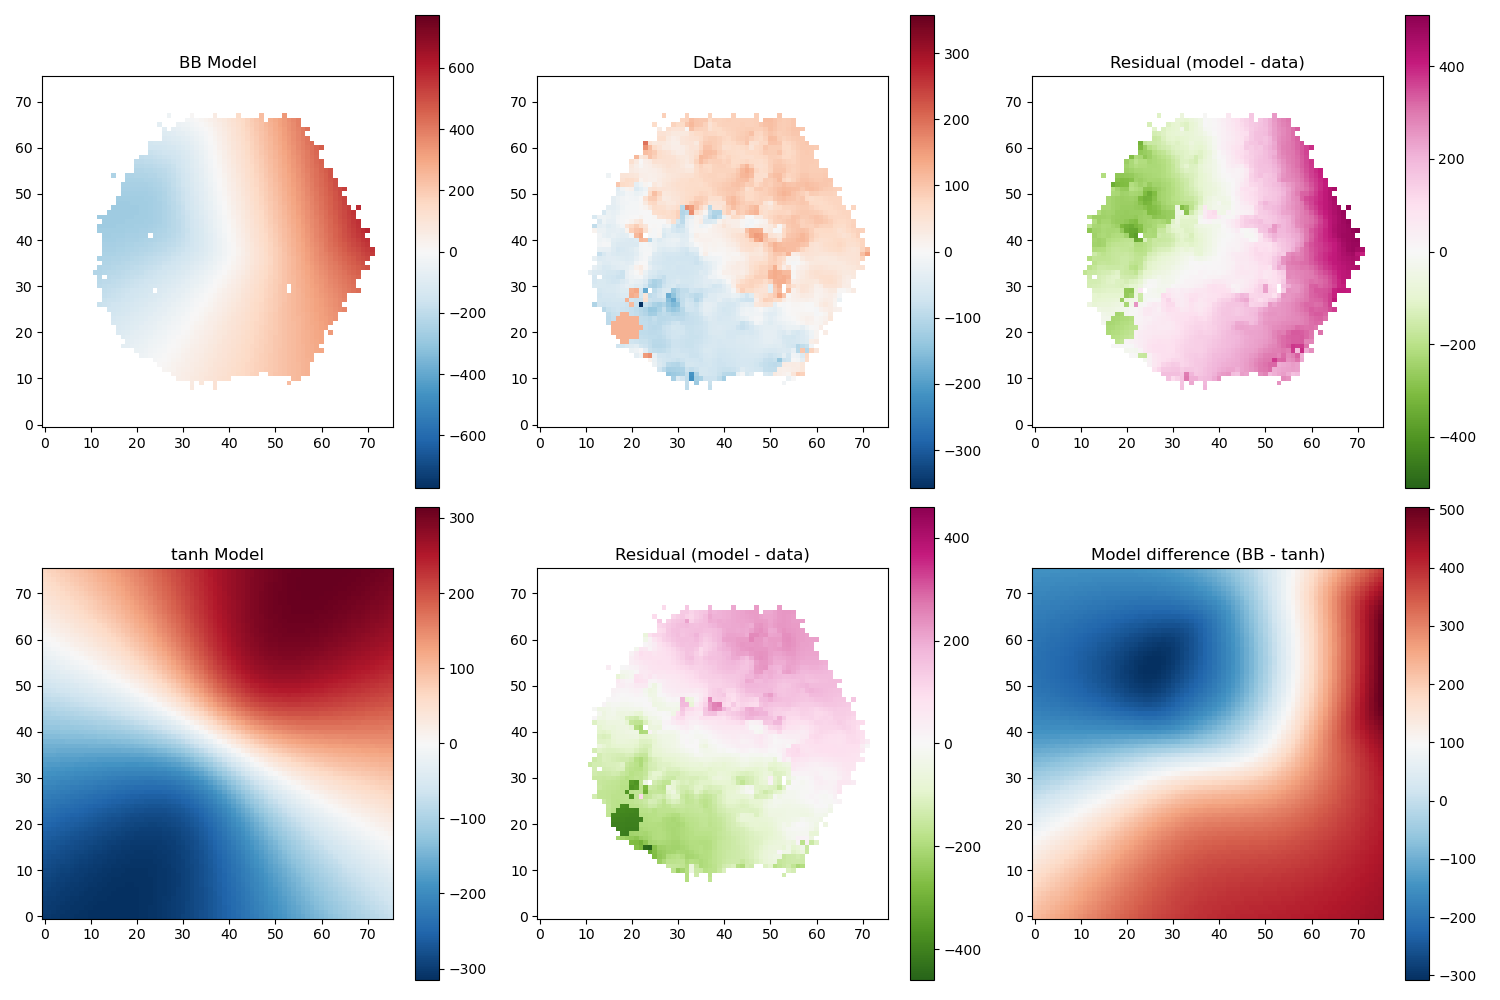

In [48]:
plt.figure(figsize=(15,10))

plt.subplot(231)
v_max_model_BB = np.max(np.abs(model_map_BB - v_sys))
plt.imshow(ma.array(model_map_BB - v_sys, mask=mHa_vel.mask), 
           vmin=-v_max_model_BB, vmax=v_max_model_BB, 
           origin='lower', 
           cmap='RdBu_r')
plt.colorbar()
plt.title('BB Model')

plt.subplot(232)
extreme2 = np.max(np.abs(mHa_vel))
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-extreme2, vmax=extreme2)
plt.colorbar()
plt.title('Data')

plt.subplot(233)
residual_BB = np.max(np.abs(model_map_BB - mHa_vel))
plt.imshow(model_map_BB - mHa_vel, origin='lower', cmap='PiYG_r', vmin=-residual_BB, vmax=residual_BB)
plt.colorbar()
plt.title('Residual (model - data)')

plt.subplot(234)
plt.imshow(model_map_tanh - v_sys, origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.title('tanh Model')

plt.subplot(235)
residual_tanh = np.max(np.abs(model_map_tanh - mHa_vel))
plt.imshow(model_map_tanh - mHa_vel, origin='lower', cmap='PiYG_r', vmin=-residual_tanh, vmax=residual_tanh)
plt.colorbar()
plt.title('Residual (model - data)')

plt.subplot(236)
plt.imshow(model_map_BB - model_map_tanh, origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.title('Model difference (BB - tanh)')

plt.tight_layout();

# Test `plot_rot_curve`

<IPython.core.display.Javascript object>


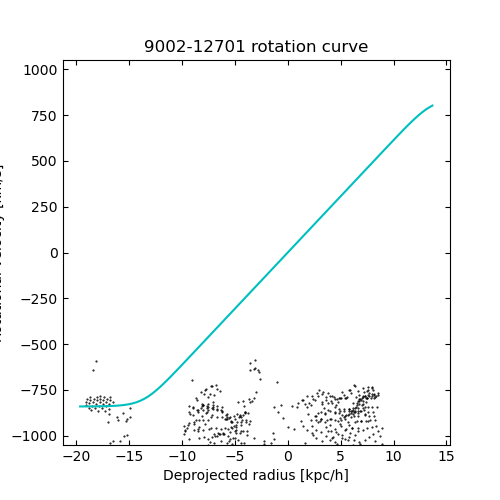

In [44]:
#plot_rot_curve(mHa_vel, mHa_vel_ivar, best_fit_values_degrees, pix_scale_factor, gal_ID, 'BB');
plot_rot_curve(mHa_vel, mHa_vel_ivar, fit_params_dict, pix_scale_factor, gal_ID, 'BB');

<IPython.core.display.Javascript object>


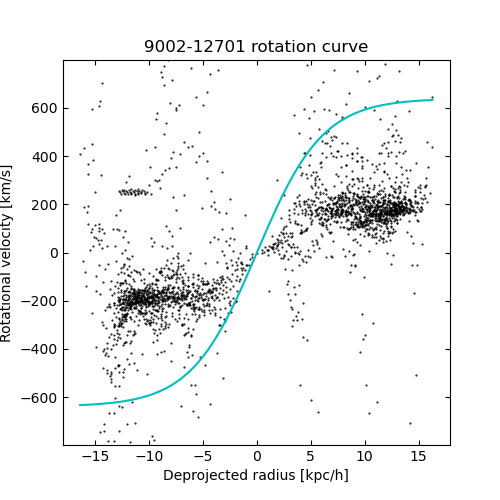

In [12]:
plot_rot_curve(mHa_vel, mHa_vel_ivar, best_fit_values_degrees, pix_scale_factor, gal_ID, 'tanh')

<IPython.core.display.Javascript object>


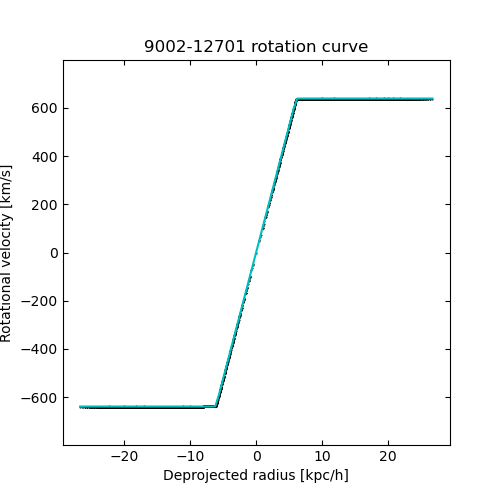

In [13]:
model_map_BB_masked = ma.array(model_map_BB, mask=np.zeros(map_shape))

plot_rot_curve(model_map_BB_masked, mHa_vel_ivar, best_fit_values_degrees, pix_scale_factor, gal_ID, 'BB');

# Test `find_center`

In [9]:
maybe_center = find_center(mHa_vel)

In [10]:
maybe_center

(43, 46)

<IPython.core.display.Javascript object>


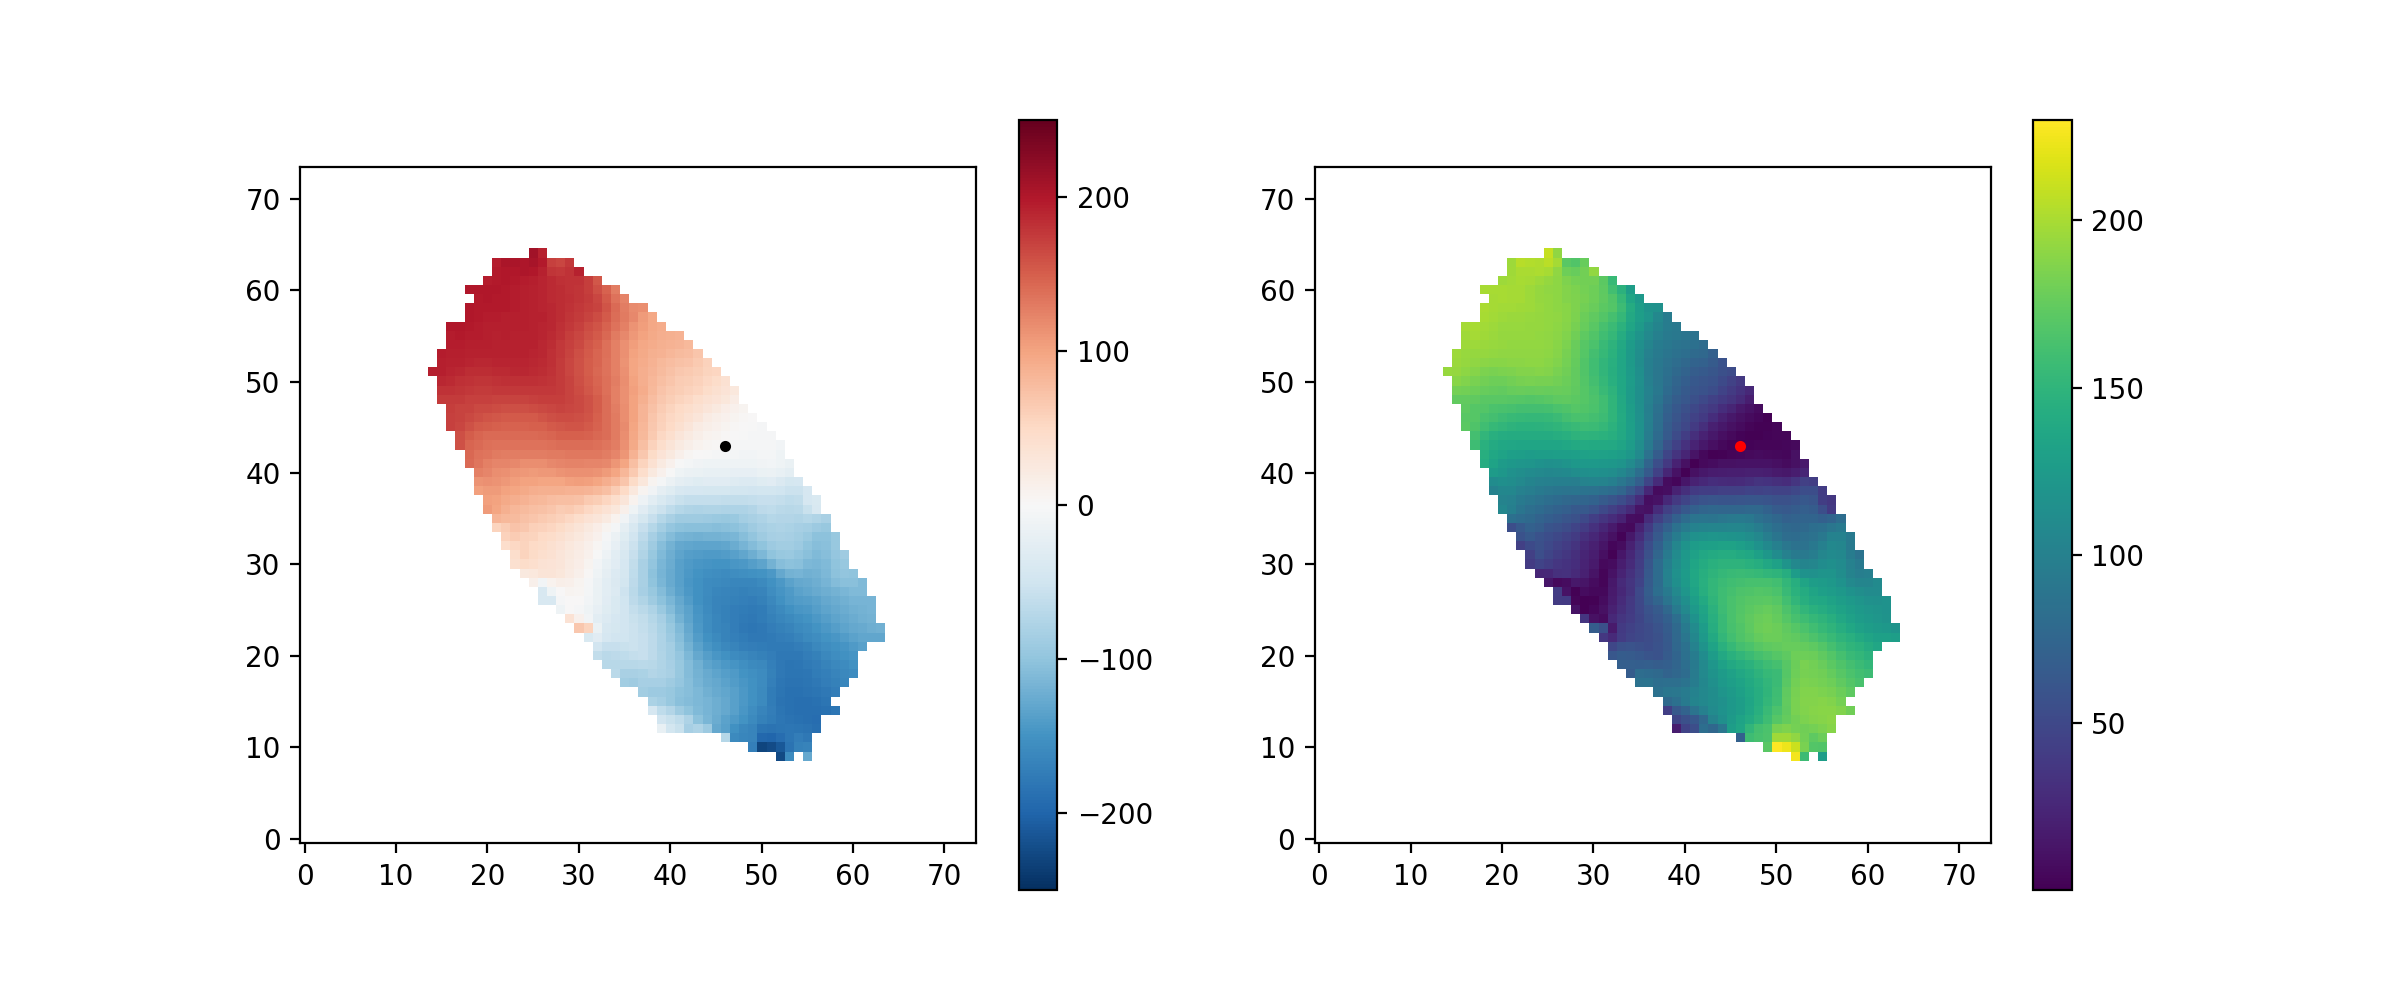

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-250, vmax=250)
plt.plot(maybe_center[1], maybe_center[0], 'k.')
plt.colorbar()

plt.subplot(122)
plt.imshow(np.abs(mHa_vel), origin='lower')
plt.plot(maybe_center[1], maybe_center[0], 'r.')
plt.colorbar();

In [12]:
x = np.arange(map_shape[0])
X, Y = np.meshgrid(x,x)

<IPython.core.display.Javascript object>


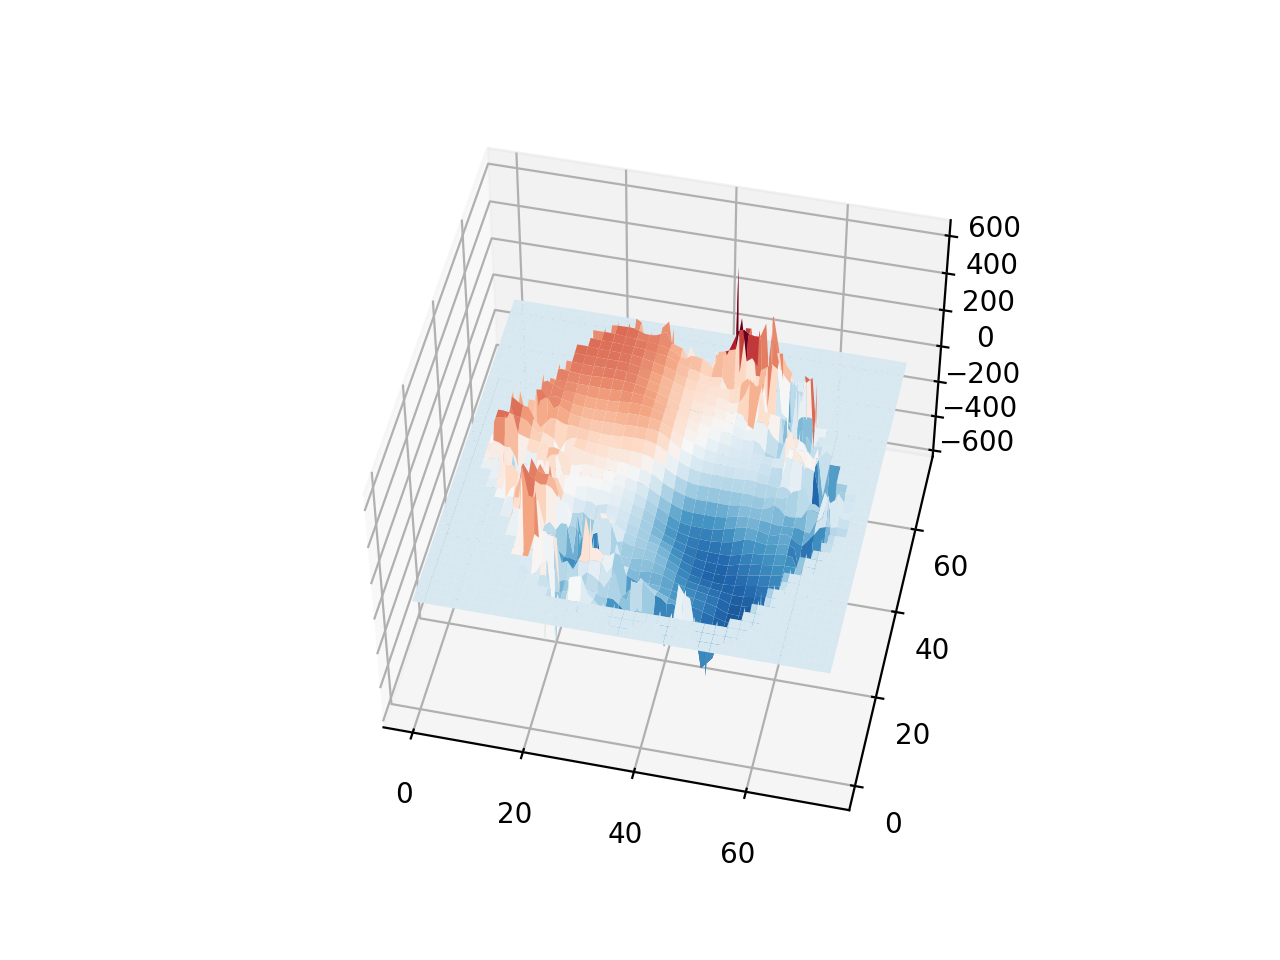

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, mHa_vel, cmap='RdBu_r');
#plt.colorbar();

In [28]:
i_angle

1.0683978716829448